In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 88% 131M/149M [00:00<00:00, 160MB/s]
100% 149M/149M [00:00<00:00, 178MB/s]


In [3]:
! unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# import zipfile
# zip_path = '/content/drive/MyDrive/combine data.zip'
# extract_path = '/content/data'  # Change this to the desired extraction path
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [6]:
import os
import math
import random
import shutil
import cv2
import imutils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from PIL import Image
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Concatenate, Conv2D, Input, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
def create_directory(directory_name, base_path="/content/"):
    directory_path = os.path.join(base_path, directory_name)
    try:
        os.makedirs(directory_path, exist_ok=True)
        print(f"Directory '{directory_name}' created at: {directory_path}")
    except Exception as e:
        print(f"Error creating directory '{directory_name}': {e}")

def create_directories(base_path, directories_to_create):
    for directory in directories_to_create:
        directory_path = os.path.join(base_path, directory)
        try:
            os.makedirs(directory_path, exist_ok=True)
            print(f"Directory '{directory}' created at: {directory_path}")
        except Exception as e:
            print(f"Error creating directory '{directory}': {e}")

# List of directory names you want to create
directories_to_create = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Specify the base paths where you want to create these directories
base_path_train = "/content/train_data_processed"
base_path_test = "/content/test_data_processed"

# Create directories for training data
create_directories(base_path_train, directories_to_create)

# Create directories for test data
create_directories(base_path_test, directories_to_create)

Directory 'glioma' created at: /content/train_data_processed/glioma
Directory 'meningioma' created at: /content/train_data_processed/meningioma
Directory 'pituitary' created at: /content/train_data_processed/pituitary
Directory 'notumor' created at: /content/train_data_processed/notumor
Directory 'glioma' created at: /content/test_data_processed/glioma
Directory 'meningioma' created at: /content/test_data_processed/meningioma
Directory 'pituitary' created at: /content/test_data_processed/pituitary
Directory 'notumor' created at: /content/test_data_processed/notumor


In [8]:
def pad_image_to_square(image):
    h, w = image.shape

    # Determine the maximum dimension among height and width
    max_dim = max(h, w)

    # Create a square canvas with dimensions equal to the maximum dimension
    padded_image = np.zeros((max_dim, max_dim), dtype=np.uint8)

    # Calculate the starting indices to place the original image within the padded canvas
    start_h = (max_dim - h) // 2
    start_w = (max_dim - w) // 2

    # Copy the original image onto the padded canvas at the calculated starting indices
    padded_image[start_h:start_h+h, start_w:start_w+w] = image

    # If the original image was not square, adjust the padding to maintain the original aspect ratio
    if h != w:
        if h > w:
            # Image is taller than it is wide
            border_left = 0
            border_right = 0
            border_top = (h - w) // 2
            border_bottom = (h - w) - border_top
        else:
            # Image is wider than it is tall
            border_top = 0
            border_bottom = 0
            border_left = (w - h) // 2
            border_right = (w - h) - border_left

        # Add borders to maintain the original aspect ratio
        padded_image = cv2.copyMakeBorder(padded_image, border_top, border_bottom, border_left, border_right, cv2.BORDER_CONSTANT, value=0)

    return padded_image

def crop_contour_brain_img(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    grayscale = cv2.GaussianBlur(grayscale, (5, 5), 0)
    threshold_image = cv2.erode(grayscale, None, iterations=2)
    threshold_image = cv2.dilate(threshold_image, None, iterations=2)

    contour = cv2.findContours(threshold_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)

    c = max(contour, key=cv2.contourArea)

    extreme_pnts_left = tuple(c[c[:, :, 0].argmin()][0])
    extreme_pnts_right = tuple(c[c[:, :, 0].argmax()][0])
    extreme_pnts_top = tuple(c[c[:, :, 1].argmin()][0])
    extreme_pnts_bot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extreme_pnts_top[1]:extreme_pnts_bot[1], extreme_pnts_left[0]:extreme_pnts_right[0]]

    return new_image

def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Apply your existing cropping and contour extraction code
    cropped_image = crop_contour_brain_img(image)

    # Intensity normalization using CLAHE
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8, 8))
    normalized_image = clahe.apply(gray)

    # Skull stripping using thresholding and morphological operations
    _, thresholded_image = cv2.threshold(normalized_image, 30, 255, cv2.THRESH_BINARY)
    skull_stripped_image = cv2.bitwise_and(normalized_image, normalized_image, mask=thresholded_image)

    # Noise reduction using bilateral filtering
    denoised_image = cv2.bilateralFilter(skull_stripped_image, 7, 60, 90)

    # Padding to maintain aspect ratio
    padded_image = pad_image_to_square(denoised_image)

    # Resize the cropped image to 299x299 for consistency
    final_image = cv2.resize(padded_image, (224, 224))

    return final_image

In [9]:
def preprocess_and_save(input_path, output_path):
    preprocessed_image = preprocess_image(input_path)
    cv2.imwrite(output_path, preprocessed_image)

def process_tumor_types(tumor_types, input_base, output_base):
    for tumor_type in tumor_types:
        input_directory = os.path.join(input_base, tumor_type)
        output_directory = os.path.join(output_base, tumor_type)

        # Ensure the output directory exists
        os.makedirs(output_directory, exist_ok=True)

        # Iterate through all files in the input directory
        for filename in os.listdir(input_directory):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Case-insensitive check for file extensions
                input_path = os.path.join(input_directory, filename)
                output_path = os.path.join(output_directory, filename)

                # Preprocess and save the image
                preprocess_and_save(input_path, output_path)

# Base directories
input_base_directory_train = "/content/Training"
input_base_directory_test = "/content/Testing"

output_base_directory_train = "/content/train_data_processed"
output_base_directory_test = "/content/test_data_processed"

# Tumor types to process
tumor_types_to_process = ["glioma", "meningioma", "pituitary", "notumor"]  # Add more types if needed

# Process tumor types for training data
process_tumor_types(tumor_types_to_process, input_base_directory_train, output_base_directory_train)

# Process tumor types for test data
process_tumor_types(tumor_types_to_process, input_base_directory_test, output_base_directory_test)

In [10]:
def augment_images_in_directory(original_directory, num_augmented_images=3):
    # Create an ImageDataGenerator instance with desired augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True
    )

    # List all subdirectories in the original directory
    subdirectories = [d for d in os.listdir(original_directory) if os.path.isdir(os.path.join(original_directory, d))]

    # Iterate through each subdirectory
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(original_directory, subdirectory)

        # List all image files in the subdirectory
        image_files = [f for f in os.listdir(subdirectory_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Perform augmentation for each image in the subdirectory
        for filename in image_files:
            original_image_path = os.path.join(subdirectory_path, filename)

            # Load the original image
            original_image = Image.open(original_image_path)
            original_image = original_image.convert("RGB")

            # Reshape the image to (height, width, channels)
            original_image_array = img_to_array(original_image)

            # Add an extra dimension to make it (1, height, width, channels)
            original_image_array = np.expand_dims(original_image_array, axis=0)

            # Generate augmented images
            augmented_images = datagen.flow(original_image_array, batch_size=1, save_to_dir=subdirectory_path, save_prefix='aug', save_format='jpeg')

            # Generate and save num_augmented_images augmented images
            for i in range(num_augmented_images):
                next(augmented_images)

    print(f"Augmentation completed for all subdirectories in {original_directory}.")

# Specify the path to your main directory
main_directory = "/content/train_data_processed"

# Set the number of augmented images you want to generate for each original image
num_augmented_images = 1

# Perform augmentation for each subdirectory within the main directory
augment_images_in_directory(main_directory, num_augmented_images)

Augmentation completed for all subdirectories in /content/train_data_processed.


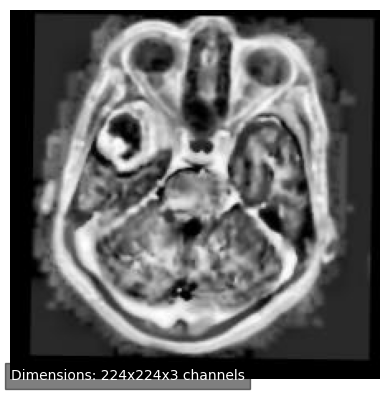

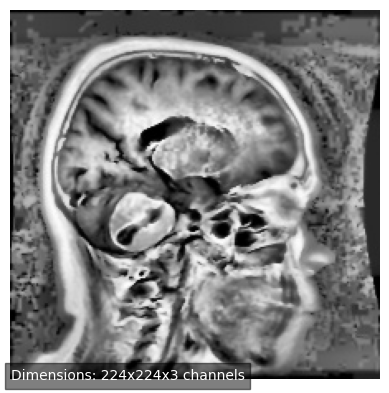

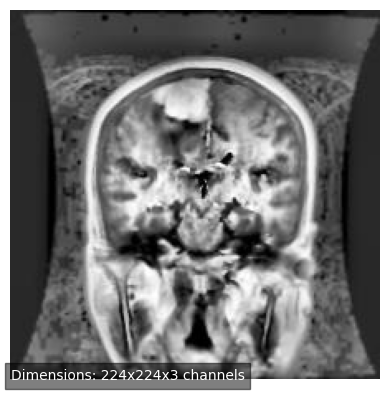

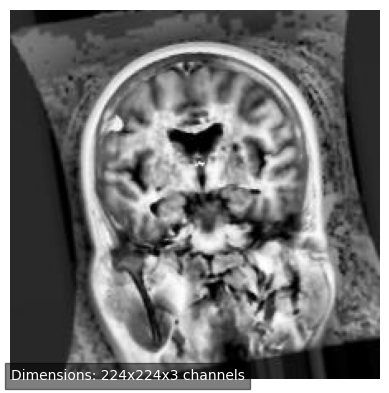

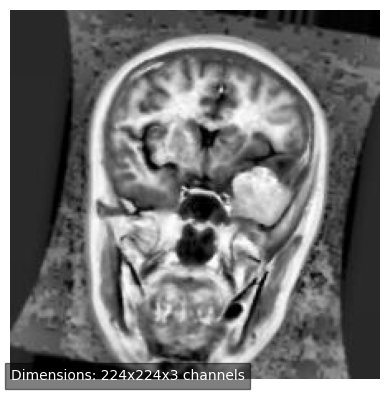

In [11]:
def show_random_images(directory):
  # List all files in the directory
  files = os.listdir(directory)

  # Randomly select 5 files
  random_files = random.sample(files, 5)

  # Loop through each randomly selected image
  for file in random_files:
    # Construct the full path to the image
    image_path = os.path.join(directory, file)

    # Read the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB (matplotlib expects RGB format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image dimensions (height, width, channels)
    height, width, channels = image.shape

    # Create a figure for displaying the image and dimensions
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis('off')  # Turn off axis

    # Add text with image dimensions in the top left corner
    text = f"Dimensions: {width}x{height}x{channels} channels"
    ax.text(0, height, text, color='white', fontsize=10, bbox=dict(facecolor='black', alpha=0.5))

    # Display the image with dimensions
    plt.show()
# Example usage:
directory = '/content/train_data_processed/meningioma'
show_random_images(directory)

In [12]:
train_dataset_dir='/content/train_data_processed'
test_dataset_dir='/content/test_data_processed'

In [13]:
# Set the image size and batch size for training
input_shape = (224,224,3)
batch_size = 16

In [14]:
# Normalization and validation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2
)

In [15]:
# Load the training dataset
train_generator = train_datagen.flow_from_directory(
    train_dataset_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 8830 images belonging to 4 classes.


In [16]:
# Load the validation dataset with data augmentation and validation split
validation_generator = train_datagen.flow_from_directory(
    train_dataset_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set to 'validation' for the validation split
)

Found 2206 images belonging to 4 classes.


In [17]:
# Get the list of subdirectories (class names)
class_names = os.listdir(train_dataset_dir)

print("Class names:", class_names)

num_classes = len(class_names)
unique_labels = class_names

Class names: ['notumor', 'meningioma', 'glioma', 'pituitary']


In [18]:
test_data_generator = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to the range [0, 1]
    # Add any other preprocessing options if needed
)

test_generator = test_data_generator.flow_from_directory(
    test_dataset_dir,
    target_size=input_shape[:2],  # Adjust to match your model's input size
    batch_size= batch_size,           # Adjust batch size as needed
    class_mode='categorical',  # If you have class labels
    shuffle=False              # Do not shuffle test data
)

Found 1311 images belonging to 4 classes.


In [32]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.applications import VGG19

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.query_dense = Dense(self.units)
        self.key_dense = Dense(self.units)
        self.value_dense = Dense(input_shape[-1])

    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Calculate dot products of queries and keys for all pairs
        dot_products = tf.einsum('bij,bkj->bik', query, key)

        # Scale by square root of the dimension of key vectors
        dot_products /= tf.sqrt(tf.cast(tf.shape(key)[-1], dot_products.dtype))

        # Apply softmax to get attention scores
        attention_scores = tf.nn.softmax(dot_products, axis=-1)

        # Weighted sum of values using the attention scores
        weighted_values = tf.einsum('bij,bjk->bik', attention_scores, value)

        return weighted_values

def build_model(input_shape, num_classes):
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    last_three_layers = ['block5_pool', 'block4_pool', 'block3_pool']
    layers_output = [base_model.get_layer(name).output for name in last_three_layers]

    pooled_outputs = [GlobalAveragePooling2D()(output) for output in layers_output]
    normalized_outputs = [BatchNormalization()(pooled_output) for pooled_output in pooled_outputs]
    flattened_normalized_outputs = [Flatten()(normalized_output) for normalized_output in normalized_outputs]
    fcnn_outputs = [Dense(256, activation='relu')(flattened_output) for flattened_output in flattened_normalized_outputs]

    attention_outputs = [SelfAttention(256)(tf.expand_dims(fcnn_output, axis=1)) for fcnn_output in fcnn_outputs]

    reshaped_attention_outputs = [Reshape((256,))(attention_output) for attention_output in attention_outputs]

    concatenated = Concatenate()(reshaped_attention_outputs)
    x = Dropout(0.5)(concatenated)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    return model

model = build_model(input_shape, num_classes)

80134624/80134624 [==============================] - 1s 0us/step


In [33]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0, from_logits=False, reduction=tf.keras.losses.Reduction.NONE, name='focal_loss'):
        super(FocalLoss, self).__init__(reduction=reduction, name=name)
        self.alpha = alpha
        self.gamma = gamma
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if self.from_logits:
            y_pred = tf.nn.sigmoid(y_pred)

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        ce = -y_true * tf.math.log(y_pred)
        weight = tf.pow(1 - y_pred, self.gamma)
        fl = self.alpha * ce * weight

        return fl

In [34]:
learning_rate = 0.0001

In [35]:
focal_loss = FocalLoss()
# Compile model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=focal_loss,
              metrics=['accuracy'])

In [36]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=50,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [37]:
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size),
                    validation_steps = math.ceil(validation_generator.samples / validation_generator.batch_size),
                    callbacks=[early_stopping])  # Include EarlyStopping callback

Epoch 1/30
552/552 [==============================] - 71s 111ms/step - loss: 0.0262 - accuracy: 0.6693 - val_loss: 0.0133 - val_accuracy: 0.8459
Epoch 2/30
552/552 [==============================] - 59s 107ms/step - loss: 0.0126 - accuracy: 0.8138 - val_loss: 0.0109 - val_accuracy: 0.8694
Epoch 3/30
552/552 [==============================] - 60s 108ms/step - loss: 0.0092 - accuracy: 0.8590 - val_loss: 0.0088 - val_accuracy: 0.8790
Epoch 4/30
552/552 [==============================] - 60s 109ms/step - loss: 0.0078 - accuracy: 0.8762 - val_loss: 0.0069 - val_accuracy: 0.8948
Epoch 5/30
552/552 [==============================] - 61s 110ms/step - loss: 0.0067 - accuracy: 0.8891 - val_loss: 0.0051 - val_accuracy: 0.9098
Epoch 6/30
552/552 [==============================] - 61s 110ms/step - loss: 0.0059 - accuracy: 0.8991 - val_loss: 0.0046 - val_accuracy: 0.9234
Epoch 7/30
552/552 [==============================] - 61s 110ms/step - loss: 0.0052 - accuracy: 0.9105 - val_loss: 0.0045 - val_ac

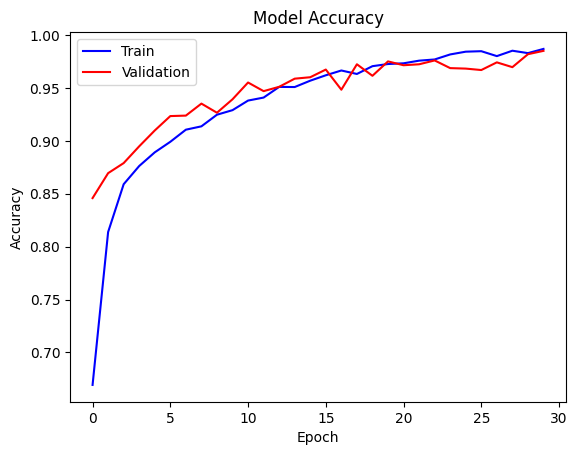

In [38]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'],'b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'],'r', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

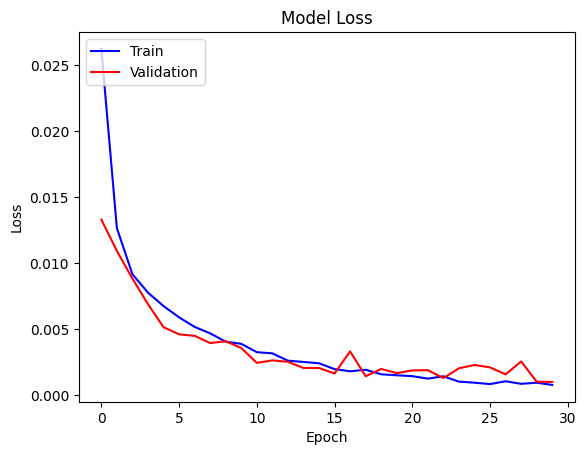

In [39]:
# Plot the training and validation loss
plt.plot(history.history['loss'],'b', label='Training loss')
plt.plot(history.history['val_loss'],'r', label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

82/82 [==============================] - 10s 122ms/step


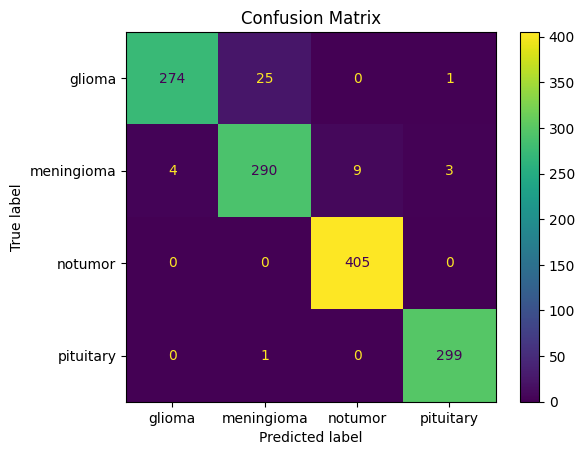

In [40]:
#  the true labels and predicted labels for the validation dataset
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

In [41]:
from sklearn.metrics import classification_report

# Compute classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

# Print the classification report
print(report)

              precision    recall  f1-score   support

      glioma       0.99      0.91      0.95       300
  meningioma       0.92      0.95      0.93       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.96      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [42]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

In [43]:
print("Accuracy:", accuracy)

for class_label, p, r, f in zip(range(len(precision)), precision, recall, f1):
    print(f"Class {class_label} - Precision: {p}, Recall: {r}, F1-score: {f}")

Accuracy: 0.9672006102212052
Class 0 - Precision: 0.9856115107913669, Recall: 0.9133333333333333, F1-score: 0.9480968858131488
Class 1 - Precision: 0.9177215189873418, Recall: 0.9477124183006536, F1-score: 0.932475884244373
Class 2 - Precision: 0.9782608695652174, Recall: 1.0, F1-score: 0.989010989010989
Class 3 - Precision: 0.9867986798679867, Recall: 0.9966666666666667, F1-score: 0.9917081260364843


In [44]:
from sklearn.metrics import matthews_corrcoef

# Compute MCC for each class
mcc_per_class = {}
for class_label in range(num_classes):
    mcc = matthews_corrcoef(y_true == class_label, y_pred == class_label)
    mcc_per_class[class_label] = mcc

# Print MCC for each class
for class_label, mcc in mcc_per_class.items():
    print(f"Class {class_label} - MCC: {mcc}")

Class 0 - MCC: 0.9345607615928845
Class 1 - MCC: 0.9116854965187708
Class 2 - MCC: 0.9841458460805572
Class 3 - MCC: 0.9892523800365007


In [ ]:
model.save('InceptionV3_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
